# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernable landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

**Note**: Remember that the dataset can be found at `/data/landmark_images/` in the workspace.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
import os
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from copy import deepcopy
from PIL import Image
from math import sqrt
import numpy as np
import sys
import gc
import tqdm
import matplotlib.pyplot as plt

'0.13.1+cu113'

In [ ]:
%%capture
#get required versioning and restart kernel if required
restart_kernel = False
if np.__version__ != '1.19.5':
    !{sys.executable} -m pip install numpy==1.19.5
    restart_kernel = True
if torch.__version__ != '1.7.0':
    !{sys.executable} -m pip install torch==1.7.0 
    restart_kernel = True
if torchvision.__version__ != '0.8.0':
    !{sys.executable} -m pip install -U torchvision==0.8.0 --ignore-installed
    restart_kernel = True
if tqdm.__version__ != '4.64.0':
    !{sys.executable} -m pip uninstall tqdm -y
    !{sys.executable} -m pip install tqdm 
if restart_kernel: 
    os._exit(00)

In [3]:
os.path.isdir('/content/drive/MyDrive/train')

True

In [38]:
#crete dataset objects, random split for train and validation
train_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/train')
train_size = int(0.80*len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
val_dataset.dataset = deepcopy(train_dataset.dataset)
test_dataset = torchvision.datasets.ImageFolder('/content/drive/MyDrive/test')

In [39]:
#get distribution of labels in both training and validation
len(train_dataset), len(val_dataset)

(3996, 1000)

In [ ]:
# #create custom Datasets Objects
# class CustomImageDataset(Dataset):
#     def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
#         self.img_labels = pd.read_csv(annotations_file)
#         self.img_dir = img_dir
#         self.transform = transform
#         self.target_transform = target_transform

#     def __len__(self):
#         return len(self.img_labels)

#     def __getitem__(self, idx):
#         img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
#         image = read_image(img_path)
#         label = self.img_labels.iloc[idx, 1]
#         if self.transform:
#             image = self.transform(image)
#         if self.target_transform:
#             label = self.target_transform(label)
#         return image, label

ModuleNotFoundError: No module named 'torchvision.io'

In [6]:
def get_mean_pixels(dataset):
    """
    returns mean pixels per channel for dataset centering
    """
    r_total, g_total, b_total = 0,0,0
    px_total = 0
    t = tqdm.tqdm(total=len(dataset))
    for img, _ in dataset:
        img = TF.to_tensor(img)
        r_sum, g_sum, b_sum = torch.sum(img, dim=(1,2))
        r_total += r_sum 
        g_total += g_sum
        b_total += b_sum
        t.update(1)

        px_total += img.shape[1] * img.shape[2]
    t.close()
    return (r_total/px_total, g_total/px_total, b_total/px_total)


In [7]:
#mean of each image channel 
r_mean, g_mean, b_mean = get_mean_pixels(train_dataset) #image tensor means of each channel, this restricts it to be [0-1]

100%|██████████| 4496/4496 [1:06:39<00:00,  1.12it/s]


In [8]:
r_mean, g_mean, b_mean 

(tensor(0.4638), tensor(0.4718), tensor(0.4668))

In [88]:

#Defines transformations applied on the full dataset 
gen_transforms = [
                    transforms.Resize(256), #set to 256x256, if square, else take shorter side, resize to 256
                    transforms.CenterCrop(256),    #applicable if input image was non-square
                    transforms.ToTensor(),        #take center 256, scales it to be [0-1] and converts dim to (C,H,W)
                    transforms.Normalize([0.4638, 0.4718, 0.4668], #center based off of mean of each color channel
                                            [1.0,1.0,1.0])
                    ]
#val_transforms = gen_transforms + [transforms.Resize(224)]

train_transforms = gen_transforms + [
                                       transforms.RandomCrop(224), #extracting random 224x224 patches + horizontal rotations to acheive translations 
                                       transforms.RandomHorizontalFlip(0.5)
                                        # TODO: Altered intensities of RGB pixel values via PCA on training set 
                                    ]
test_transforms = gen_transforms + [
                                    transforms.FiveCrop(224),
                                    transforms.Lambda(lambda crops: torch.stack([crop for crop in crops]))
                                    ]

#apply transformations on datasets
train_dataset.dataset.transform = transforms.Compose(train_transforms)
val_dataset.dataset.transform = transforms.Compose(test_transforms)
test_dataset.transform = transforms.Compose(test_transforms)

In [89]:
val_dataset.dataset.transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.4638, 0.4718, 0.4668], std=[1.0, 1.0, 1.0])
    FiveCrop(size=(224, 224))
    Lambda()
)

In [80]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#use Datasets objects to create iterable dataloaders

loaders_scratch = { 'train': DataLoader(train_dataset, shuffle=True, batch_size=16), 
                    'valid': DataLoader(val_dataset, batch_size=16), 
                    'test': DataLoader(test_dataset, batch_size=16)}


In [91]:
loaders_scratch['valid'].dataset.dataset.transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.4638, 0.4718, 0.4668], std=[1.0, 1.0, 1.0])
    FiveCrop(size=(224, 224))
    Lambda()
)

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

**Answer**: 

1) My code resizes the images into 256x256 images, if the original image is nonsquare, then the shortest side is resized to 256. From there we take the center 256x256 crop. The input tensor itself is 224x224, the reason is for image augmentation. 

2) For image augmentation, I wanted to achieve translational invariance and rotational invariance. Therefore I took a random 224x224 crop and a random horizontal flip. Additionally, I centered the training set by subtracting the mean. The final input tensor is then 224x224 image

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

In [11]:
def im_convert(tensor):
    """Converts tensor image into interpretable format for plt.imshow"""
    image = tensor.clone()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0) #converts (C,H,W) -> (H,W,C) 
    image = image + np.array((r_mean, g_mean, b_mean)) #undoes our normalization #why does this make sense? This is because of broadcasting...
    image = image.clip(0,1) #restricts range of values to be between this. Which, for a tensor, is required
    return image


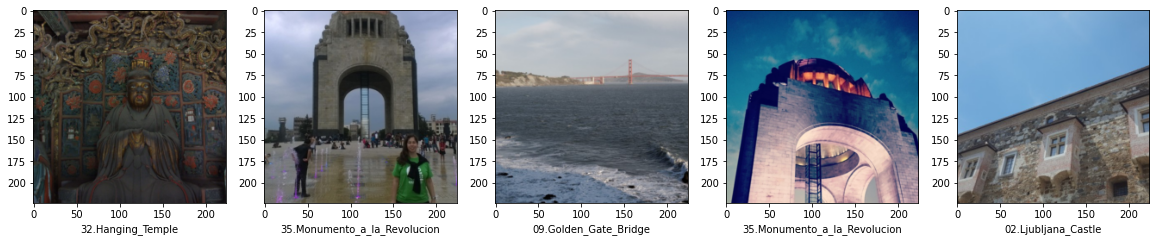

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
imgs, labels = next(iter(loaders_scratch['valid']))
#create matplot lib figure that can handle 5 images within a single figure
fig, axes = plt.subplots(1,5, figsize=(20,50))
for idx, ax in enumerate(axes): 
    ax.imshow(im_convert(imgs[idx]))
    ax.set_xlabel(train_dataset.dataset.classes[labels[idx]])




### Initialize use_cuda variable

In [8]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()
use_cuda

True

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [83]:
## TODO: select loss function
criterion_scratch = torch.nn.NLLLoss() #output of model will be log-softmax layer vector, therefore we need to log it and take cross-entropy

def get_optimizer_scratch(model):
    return torch.optim.Adam(model.parameters())
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [93]:
import torch.nn as nn

# define the CNN architecture

#TODO: If we get subpar performance, try batch norm and dropout (if overfitting)
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3,16, kernel_size=3, padding=1, stride=1)
        self.conv2 = torch.nn.Conv2d(16,32, kernel_size=3, padding=1, stride=1)
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1)
        self.fc1 = torch.nn.Linear(50176, 1000)
        self.fc2 = torch.nn.Linear(1000,50) #does this need to be the number of classes? -> yes softmax just performs the exp() function
        self.output_layer = torch.nn.LogSoftmax()
        self.pooling_layer = torch.nn.MaxPool2d(kernel_size=2, stride=2) #halves the dimensions of input
        self.relu_activation = torch.nn.ReLU() 
        #self.conv_dropout = torch.nn.Dropout2d(0.5)
        self.fc_dropout = torch.nn.Dropout(0.2)
    
    def forward(self, x):
        #Define forward behavior
        x = self.conv1(x)
        x = self.pooling_layer(x) #3x224x224 -> 16x112x112
        x = self.relu_activation(x)
        x = self.conv2(x)
        x = self.pooling_layer(x) #16x112x112 -> 32x56x56
        x = self.relu_activation(x)
        x = self.conv3(x)
        x = self.pooling_layer(x) #32x56x56 -> 64x28x28
        x = self.relu_activation(x)
        x = x.flatten(start_dim=1) #(batch_size, 100352)
        x = self.fc_dropout(self.relu_activation(self.fc1(x)))
        x = self.fc2(x)
        x = self.output_layer(x)

        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__  

I know that as we pass through our CNN, the layer depth should increase and dimensions of each channel should decrease. With this in mind the first layer is a shallow 16-channel. We then pass through 2 additonal convolutional layers, each one doubling the depth. Additionally, we use max-pooling for dimensionality reduction before each convolutional layer. 

The classifier is composed of two linear layers. In order to fit the model into our memory, the number of hidden units in the first linear layer had to reduced to 1000. 

Given this starting architecture, I recieved a test accuracy of 34%. Given that our training loss was much smaller than our validation loss, I figured I could apply regularization techniques. However, when applying dropout to every layer underfitting occured. I believe this is because our model is relatively small and shallow, so dropout forced an overly simplisitic model. I therefore only applied dropout to the first linear layer. With this I settled on a final output of 34%



### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [94]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    #total_size = len(loaders['train'].dataset) + len(loaders['valid'].dataset)
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
#         #shuffle validation and training indicies per epoch
#         indicies = np.random.permutation(total_size)
#         loaders['train'].dataset.indicies = indicies[:train_size]
#         loaders['valid'].dataset.indicies = indicies[train_size:]
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        #print('training model')
        #t = tqdm.tqdm(total = len(loaders['train']))
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad() #empty out optimizer
            y_pred = model.forward(data)
            loss = criterion(y_pred, target)
            loss.backward() #gets gradients
            #print('conv1 grad mean = {}'.format(torch.mean(model.conv1.weight.grad)))
            optimizer.step() #update parameters
            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            del data 
            del target
            gc.collect()
            torch.cuda.empty_cache()
            #t.update(1)
#             del data 
#             del target
#             torch.cuda.empty_cache()
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        #print('validating current epoch')
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            bs, n_crop, c, h, w = data.shape
            y_pred = model.forward(data.reshape(-1, c,h,w))
            y_pred = y_pred.reshape(bs, n_crop, -1).mean(1)
            loss = criterion(y_pred, target)
            ## TODO: update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))
            del data 
            del target
            gc.collect()
            torch.cuda.empty_cache()

        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [95]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy

    if isinstance(m, torch.nn.Linear):
        k = m.in_features #number of inputs into each node in the linear layer
        torch.nn.init.uniform_(m.weight, -1/sqrt(k), 1/sqrt(k))
        torch.nn.init.constant_(m.bias, 0)
    #if module is of type Conv...then use the size of kernel
    if isinstance(m, torch.nn.Conv2d):
        k = m.weight.size(1) * m.weight.size(2)* m.weight.size(3) #total parameters per activation layer
        torch.nn.init.uniform_(m.weight, -1/sqrt(k), 1/sqrt(k))

    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init) #will these apply our weight initialization strategy to each kernel within a Conv layer? 
model_scratch = train(25, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, '/content/drive/MyDrive/ignore.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 3.886730 	Validation Loss: 3.755986
Epoch: 2 	Training Loss: 3.610059 	Validation Loss: 3.540553
Epoch: 3 	Training Loss: 3.400282 	Validation Loss: 3.353139
Epoch: 4 	Training Loss: 3.180153 	Validation Loss: 3.135525
Epoch: 5 	Training Loss: 2.934331 	Validation Loss: 2.987945
Epoch: 6 	Training Loss: 2.715732 	Validation Loss: 2.952216
Epoch: 7 	Training Loss: 2.507268 	Validation Loss: 2.829088
Epoch: 8 	Training Loss: 2.316971 	Validation Loss: 2.767632
Epoch: 9 	Training Loss: 2.163586 	Validation Loss: 2.786453
Epoch: 10 	Training Loss: 1.997558 	Validation Loss: 2.844897
Epoch: 11 	Training Loss: 1.812680 	Validation Loss: 2.945837
Epoch: 12 	Training Loss: 1.661576 	Validation Loss: 3.071140
Epoch: 13 	Training Loss: 1.534518 	Validation Loss: 2.972951
Epoch: 14 	Training Loss: 1.391792 	Validation Loss: 3.120729
Epoch: 15 	Training Loss: 1.293389 	Validation Loss: 3.081676
Epoch: 16 	Training Loss: 1.130015 	Validation Loss: 3.247806
Epoch: 17 	Traini

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [96]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 15

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()


In [97]:
# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, '/content/drive/MyDrive/model_scratch.pt')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 3.823475 	Validation Loss: 3.573366
Epoch: 2 	Training Loss: 3.472444 	Validation Loss: 3.373445
Epoch: 3 	Training Loss: 3.204801 	Validation Loss: 3.201468
Epoch: 4 	Training Loss: 2.972325 	Validation Loss: 2.982401
Epoch: 5 	Training Loss: 2.778319 	Validation Loss: 2.927819
Epoch: 6 	Training Loss: 2.588938 	Validation Loss: 2.888974
Epoch: 7 	Training Loss: 2.425579 	Validation Loss: 2.840875
Epoch: 8 	Training Loss: 2.240318 	Validation Loss: 2.829541
Epoch: 9 	Training Loss: 2.112963 	Validation Loss: 2.928504
Epoch: 10 	Training Loss: 1.896411 	Validation Loss: 2.799663
Epoch: 11 	Training Loss: 1.754493 	Validation Loss: 2.878022
Epoch: 12 	Training Loss: 1.605946 	Validation Loss: 2.980675
Epoch: 13 	Training Loss: 1.447053 	Validation Loss: 3.055699
Epoch: 14 	Training Loss: 1.303894 	Validation Loss: 2.997068
Epoch: 15 	Training Loss: 1.208121 	Validation Loss: 3.140847


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [98]:
model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/model_scratch.pt'))

<All keys matched successfully>

In [34]:
import gc
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()
    t = tqdm.tqdm(total=len(loaders['test']))
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        bs, ncrops, c, h, w = data.size()
        output = model(data.view(-1, c,h,w))#fuse batch and crops
        output = output.view(bs, ncrops, -1).mean(1) #means over 5 crops
 
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1] #returns idx with largest value
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
        del data 
        del target
        torch.cuda.empty_cache()
        t.update(1)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [99]:
# load the model that got the best validation accuracy
gc.collect()
torch.cuda.empty_cache()
model_scratch.load_state_dict(torch.load('/content/drive/MyDrive/model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

100%|██████████| 79/79 [00:23<00:00,  3.41it/s]

Test Loss: 2.836361


Test Accuracy: 35% (449/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [100]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes


gen_transforms[3] = transforms.Normalize([0.485,0.456,0.406],
                                        [0.229,0.224,0.225])
train_transforms = gen_transforms + [
                                       transforms.RandomCrop(224), #extracting random 224x224 patches + horizontal rotations to acheive translations 
                                       transforms.RandomHorizontalFlip(0.5)
                                        # TODO: Altered intensities of RGB pixel values via PCA on training set 
                                    ]
test_transforms = gen_transforms + [
                                    transforms.FiveCrop(224),
                                    transforms.Lambda(lambda crops: torch.stack([crop for crop in crops]))
                                    ]

In [101]:
loaders_transfer = loaders_scratch
loaders_transfer['train'].dataset.dataset.transform = transforms.Compose(train_transforms)
loaders_transfer['valid'].dataset.dataset.transform = transforms.Compose(test_transforms)
loaders_transfer['test'].dataset.transform = transforms.Compose(test_transforms)

In [102]:
loaders_transfer['valid'].dataset.dataset.transform

Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
    CenterCrop(size=(256, 256))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    FiveCrop(size=(224, 224))
    Lambda()
)

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [103]:
## TODO: select loss function
criterion_transfer = torch.nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    return torch.optim.Adam(model.classifier.parameters())

    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [104]:
## TODO: Specify model architecture

model_transfer = torchvision.models.alexnet(pretrained=True)
model_transfer.classifier[6] = torch.nn.Linear(4096, 50)
model_transfer.classifier.apply(default_weight_init)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [74]:
model_transfer.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=50, bias=True)
)

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__  

I used Alexnet as my default model. Seeing their classifier has a couple of linear layers with dropout, I figured I'd modify the last linear layer to conform to my desired output dimensions (50). This was my initial starting point and with it I achieved an accuracy of 64%

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [105]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
train(35, loaders_transfer, model_transfer, get_optimizer_transfer(model_transfer), criterion_transfer, use_cuda, '/content/drive/MyDrive/model_transfer_80.pt')


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('/content/drive/MyDrive/model_transfer_80.pt'))

Epoch: 1 	Training Loss: 3.309861 	Validation Loss: 2.284907
Epoch: 2 	Training Loss: 2.733355 	Validation Loss: 2.144506
Epoch: 3 	Training Loss: 2.443126 	Validation Loss: 2.009444
Epoch: 4 	Training Loss: 2.340061 	Validation Loss: 1.983089
Epoch: 5 	Training Loss: 2.291368 	Validation Loss: 1.962230
Epoch: 6 	Training Loss: 2.181830 	Validation Loss: 2.015011
Epoch: 7 	Training Loss: 2.177419 	Validation Loss: 1.927806
Epoch: 8 	Training Loss: 2.020762 	Validation Loss: 1.662583
Epoch: 9 	Training Loss: 1.965141 	Validation Loss: 1.641581
Epoch: 10 	Training Loss: 1.967610 	Validation Loss: 1.678482
Epoch: 11 	Training Loss: 1.856165 	Validation Loss: 1.595035
Epoch: 12 	Training Loss: 1.820948 	Validation Loss: 1.633546
Epoch: 13 	Training Loss: 1.820485 	Validation Loss: 1.669743
Epoch: 14 	Training Loss: 1.751857 	Validation Loss: 1.607688
Epoch: 15 	Training Loss: 1.734920 	Validation Loss: 1.533175
Epoch: 16 	Training Loss: 1.640946 	Validation Loss: 1.592416
Epoch: 17 	Traini

<All keys matched successfully>

In [15]:
model_transfer.load_state_dict(torch.load('/content/drive/MyDrive/model_transfer_80.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [106]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

100%|██████████| 79/79 [00:21<00:00,  3.67it/s]

Test Loss: 1.382101


Test Accuracy: 65% (818/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [108]:
use_cuda

True

In [110]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    
    #read in image
    img = Image.open(img_path)
    
    #transform image 
    t = transforms.Compose(test_transforms)
    img_t = t(img).cuda() if use_cuda else t(img)
    
    #add dim for batch
    img_t = img_t.unsqueeze(0)
    
    #get topk predictions and indicies 
    bs, ncrops, c, h, w = img_t.size()
    output = model_transfer(img_t.view(-1, c,h,w))#fuse batch and crops
    output = output.view(bs, ncrops, -1).mean(1) #means over 5 crops
    p, idx = torch.nn.functional.softmax(output).topk(k)
    
    #get indicies corresponding labels
    return [train_dataset.dataset.classes[x] for x in idx.squeeze()]
    
# test on a sample image
predict_landmarks('/content/drive/MyDrive/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


['09.Golden_Gate_Bridge',
 '38.Forth_Bridge',
 '03.Dead_Sea',
 '06.Niagara_Falls',
 '34.Great_Barrier_Reef']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


09.Golden_Gate_Bridge, 38.Forth_Bridge, 03.Dead_Sea



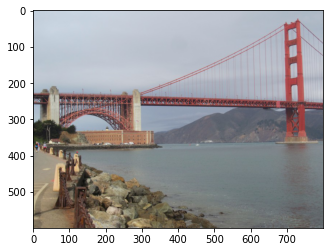

In [111]:
def suggest_locations(img_path, ax=None):
    # get landmark predictions
    predicted_landmarks = ', '.join(predict_landmarks(img_path, 3))
    
    ## TODO: display image and display landmark predictions
    img = Image.open(img_path)
    if ax: 
      ax.imshow(img)
      #ax.set_title(predicted_landmarks)
    else:
      plt.imshow(img)
      #plt.title(predicted_landmarks)
    print(predicted_landmarks + '\n')


# test on a sample image
suggest_locations('/content/drive/MyDrive/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)


The output is worse than I expected. I think this can be improved by using more data in training, which would require some form of syntehtic data generation. Additionally, having more compute resources to speed up training would also be benefical. Due to time constraints I had to limit the number of epochs to 35. According to the loss trends, the model would have continued to improve if more epcohs were used. Finally, a variable learning rate could've been useful as we started to converge toward the end of training. A variable learning rate could have potentially overcome the convergence for reduced loss 

In [112]:
img_dir = '/content/drive/MyDrive/my_imgs'
os.listdir(img_dir)

['taj.jpg', 'grand_canyon.jpg', 'washington_mon.jpg', 'yellow_stone.jpg']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


45.Temple_of_Heaven, 40.Stockholm_City_Hall, 17.Changdeokgung

18.Delicate_Arch, 08.Grand_Canyon, 36.Badlands_National_Park

31.Washington_Monument, 16.Eiffel_Tower, 21.Taj_Mahal

03.Dead_Sea, 34.Great_Barrier_Reef, 27.Seattle_Japanese_Garden



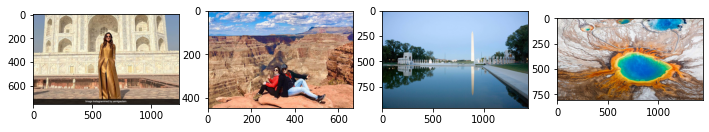

In [113]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
img_dir = '/content/drive/MyDrive/my_imgs'
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,12))
for i,img_f in enumerate(os.listdir(img_dir)):
  suggest_locations(os.path.join(img_dir, img_f), ax=axes[i])

